In [36]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [39]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-3381537384.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3381537384.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3381537384.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3381537384.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


/tmp/ipython-input-3381537384.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3381537384.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [40]:
# 1. 3D 데이터를 2D로 변환 (스케일러 적용을 위해)
n_features = trainX.shape[2] # 13번 셀에 있지만 여기서 미리 사용
trainX_reshaped = trainX.reshape(-1, n_features)
testX_reshaped = testX.reshape(-1, n_features)

# 2. StandardScaler 객체 생성 및 '훈련 데이터'로 'fit'
scaler = StandardScaler()
scaler.fit(trainX_reshaped)

# 3. 훈련 데이터와 테스트 데이터 'transform' (스케일링 적용)
trainX_scaled_reshaped = scaler.transform(trainX_reshaped)
testX_scaled_reshaped = scaler.transform(testX_reshaped)

# 4. 스케일링된 2D 데이터를 다시 3D로 변환
trainX = trainX_scaled_reshaped.reshape(trainX.shape)
testX = testX_scaled_reshaped.reshape(testX.shape)

In [41]:
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [42]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [43]:
# LSTM 모델 정의
lstm_model = Sequential()

lstm_model.add(LSTM(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
lstm_model.add(Dropout(0.4))
lstm_model.add(LSTM(128))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dense(n_outputs, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 128, 128)       │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,526 (857.52 KB)

 Trainable params: 219,526 (857.52 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model_history = lstm_model.fit(X_train, y_train_one_hot, epochs=30, batch_size=32, validation_data=(X_val, y_val_one_hot))

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6191 - loss: 0.9075 - val_accuracy: 0.9218 - val_loss: 0.2372
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9240 - loss: 0.2084 - val_accuracy: 0.9368 - val_loss: 0.1516
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9320 - loss: 0.1915 - val_accuracy: 0.9409 - val_loss: 0.1516
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9488 - loss: 0.1327 - val_accuracy: 0.9511 - val_loss: 0.1272
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9511 - loss: 0.1344 - val_accuracy: 0.9354 - val_loss: 0.1468
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9436 - loss: 0.1318 - val_accuracy: 0.9477 - val_loss: 0.1194
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9500 - loss: 0.1225 - val_accuracy: 0.9490 - val_loss: 0.1244
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9555 - loss: 0.1042 - val_accu

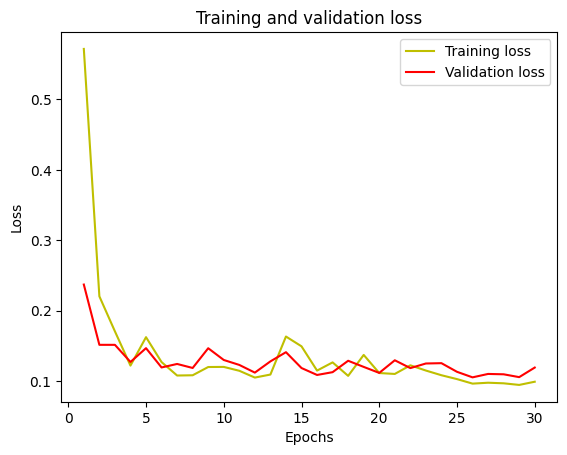

In [45]:
# 그래프

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

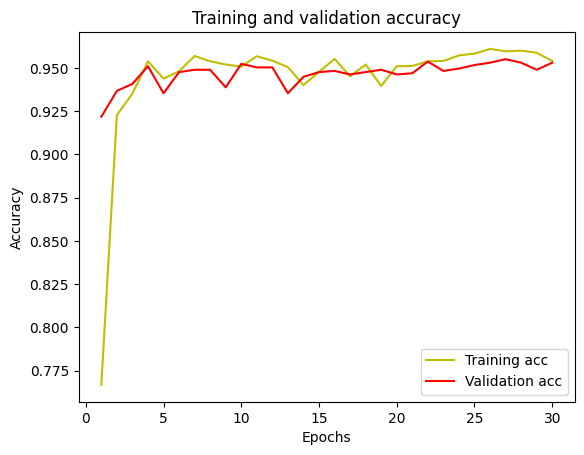

In [46]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[[485   2   7   2   0   0]
 [  1 445   4  21   0   0]
 [  0   1 419   0   0   0]
 [  0   4   0 375 107   5]
 [  0   0   0  83 449   0]
 [  0   0   0   0   0 537]]
0.9195792331184255
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       496
           1       0.98      0.94      0.96       471
           2       0.97      1.00      0.99       420
           3       0.78      0.76      0.77       491
           4       0.81      0.84      0.83       532
           5       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

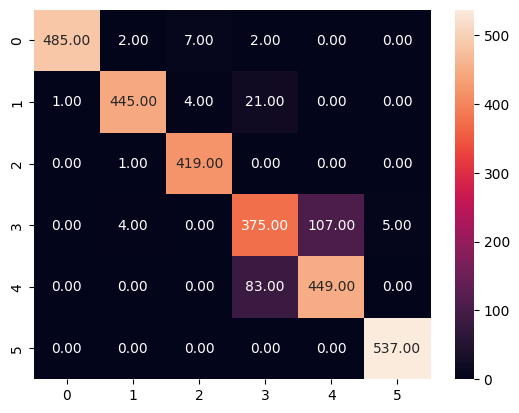

In [47]:
# 모델 평가

pred_probabilities = lstm_model.predict(testX)
pred = np.argmax(pred_probabilities, axis=-1)

cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt = '.2f')